In [50]:
import requests

def get_geocode(location: str):
    ORS_API_KEY = "5b3ce3597851110001cf624870ef7b6bd38d4031befb802c575bf729"
    ORS_GEOCODE_URL = "https://api.openrouteservice.org/geocode/search"
    
    params = {
        "api_key": ORS_API_KEY,
        "text": location,
        "size": 1,  # Get only the top result
        "boundary.city": "Coimbatore"  # Restrict to Coimbatore
    }
    
    response = requests.get(ORS_GEOCODE_URL, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if data["features"]:
            coordinates = data["features"][0]["geometry"]["coordinates"]
            return (coordinates[0],coordinates[1])
        else:
            return {"error": "No results found"}
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

In [51]:
print(get_geocode("Amrita Vishwa Vidhyapeetham Coimbatore"))

(76.899023, 10.903351)


In [18]:
def get_polyline(start: tuple, end: tuple):
    ORS_API_KEY = "5b3ce3597851110001cf624870ef7b6bd38d4031befb802c575bf729"
    ORS_DIRECTIONS_URL = "https://api.openrouteservice.org/v2/directions/driving-car/geojson"
    
    headers = {
        "Authorization": ORS_API_KEY,
        "Content-Type": "application/json"
    }
    
    body = {
        "coordinates": [
            [start[0], start[1]],  # Ensure (longitude, latitude) format
            [end[0], end[1]]
        ]
    }
    
    response = requests.post(ORS_DIRECTIONS_URL, json=body, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        if "features" in data and data["features"]:
            route = data["features"][0]
            polyline = [(coord[0], coord[1]) for coord in route["geometry"]["coordinates"]]  # Remove elevation
            return {
                "polyline": polyline,
                "distance_m": route["properties"]["segments"][0]["distance"],
                "duration_s": route["properties"]["segments"][0]["duration"]
            }
        else:
            return {"error": "No route found"}
    else:
        return {"error": f"Request failed with status code {response.status_code}, message: {response.text}"}

In [46]:

print(get_polyline(start, end))

{'error': 'Request failed with status code 404, message: {"error":{"code":2010,"message":"Could not find routable point within a radius of 350.0 meters of specified coordinate 1: 76.9542450 10.9825160."},"info":{"engine":{"build_date":"2025-01-27T14:56:02Z","graph_version":"1","version":"9.0.0"},"timestamp":1742046869984}}'}


In [38]:
from shapely.geometry import LineString, Point

def is_location_on_route(polyline, location, threshold=0.1):
    """
    Checks if a given location (longitude, latitude) is near the route polyline.
    :param polyline: List of (longitude, latitude) tuples representing the route
    :param location: Tuple (longitude, latitude) to check
    :param threshold: Distance threshold to determine if a point is on the route
    :return: True if the location is near the route, False otherwise
    """
    route_line = LineString(polyline)
    point = Point(location)
    print('distance: ',route_line.distance(point))
    return route_line.distance(point) <= threshold

In [39]:
import matplotlib.pyplot as plt
def plot_route(polyline, location):
    """
    Plots the route polyline and the location to check.
    :param polyline: List of (longitude, latitude) tuples representing the route
    :param location: Tuple (longitude, latitude) of the point to check
    """
    polyline_lons, polyline_lats = zip(*polyline)
    
    plt.figure(figsize=(8, 6))
    plt.plot(polyline_lons, polyline_lats, marker='o', linestyle='-', color='blue', label='Route')
    plt.scatter(location[0], location[1], color='red', label='Checked Location', zorder=3)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Route and Location Check')
    plt.grid()
    plt.show()


((80.312147, 17.494786), (76.161763, 10.373221))
distance:  0.001660327979647413
True


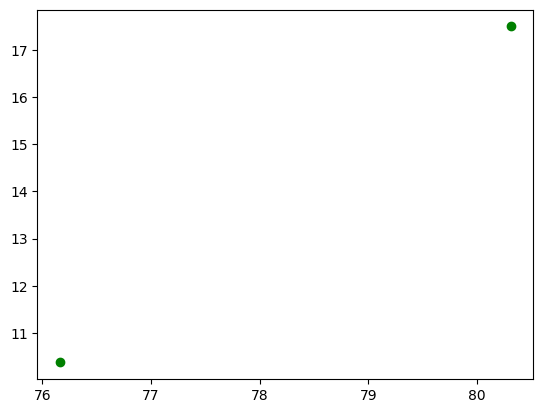

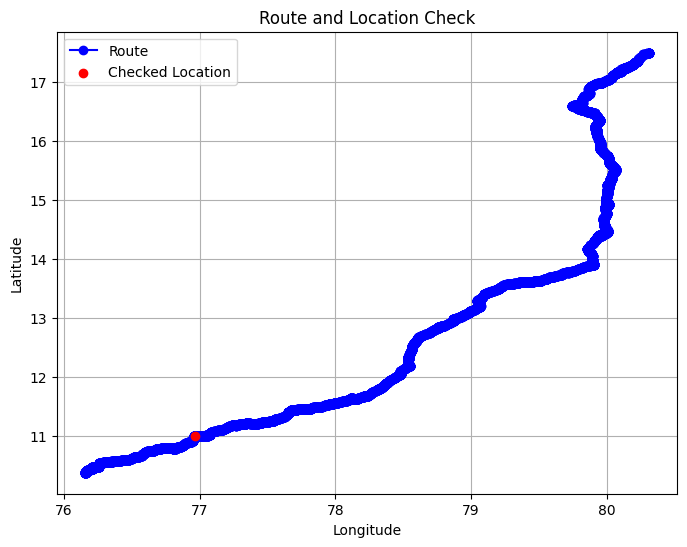

In [49]:
start = (get_geocode("Gandhipuram"))  # Example coordinates for Coimbatore
end = (get_geocode("Kattoor"))
print((start,end))
polyline_data = get_polyline(start, end)
plt.scatter(start[0],start[1],color='green')
plt.scatter(end[0],end[1],color='green')
if "polyline" in polyline_data:
    location_to_check = get_geocode("Coimbatore Junction")
    print(is_location_on_route(polyline_data["polyline"], location_to_check))
    plot_route(polyline_data["polyline"], location_to_check)